# Exercise 2 - Code

In [45]:
import networkx as nx
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use("seaborn-notebook")

path = "../data/"

## Problem 1
*Write a function that gets a Graph object as input and returns the average degree and the standard deviation. Test your function with the karate edgelist and plot its degree distribution.*

In [46]:
def avg_std_degree(G):
    degrees = list(dict(G.degree()).values())
    return np.mean(degrees), np.std(degrees)

average degree: 4.588235294117647, standard deviation: 3.820360677912828


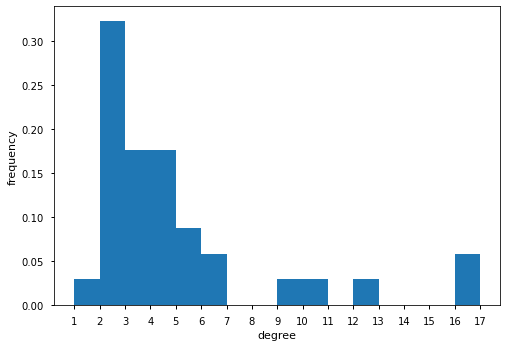

In [47]:
G = nx.read_adjlist(path+"karate_elist.txt")
degrees = list(dict(G.degree()).values())
bins = np.arange(np.min(degrees), np.max(degrees)+1)

avg, std = avg_std_degree(G)
print(f"average degree: {avg}, standard deviation: {std}")

plt.hist(degrees, bins=bins, density=True)
plt.xticks(bins)
plt.xlabel("degree")
plt.ylabel("frequency")
plt.show()

## Problem 2 

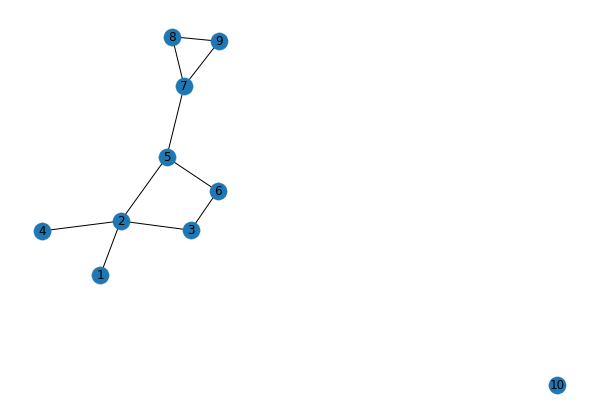

In [48]:
G = nx.Graph()
G.add_nodes_from(range(1,11))
G.add_edges_from([(1,2), (2,3), (2,4), (2,5), (3,6), (5,6), (5,7), (7,8), (7,9), (8,9)])
nx.draw(G, with_labels=True)

*a) Write the adjacency matrix and the edgelist of the network from theory-problem 3.*

In [49]:
print(nx.adjacency_matrix(G).todense())
print(G.edges)

[[0 1 0 0 0 0 0 0 0 0]
 [1 0 1 1 1 0 0 0 0 0]
 [0 1 0 0 0 1 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 1 1 0 0 0]
 [0 0 1 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 1 1 0]
 [0 0 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 1 1 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
[(1, 2), (2, 3), (2, 4), (2, 5), (3, 6), (5, 6), (5, 7), (7, 8), (7, 9), (8, 9)]


*b) Compute the clustering coefficient, diameter and density.*

In [50]:
def clustering_coefficients(G):
    coeffs = {}
    A = nx.adjacency_matrix(G)**3
    for i, node in enumerate(G.nodes):
        deg = G.degree(node)
        if deg <= 1:
            coeffs[node] = 0
        else:
            coeffs[node] = A[i,i] / deg / (deg-1)
    return coeffs

coeffs = clustering_coefficients(G)
print(coeffs)
print("average clustering coefficient:", np.mean(list(coeffs.values())))
print("estimation:", nx.average_clustering(G))

{1: 0, 2: 0.0, 3: 0.0, 4: 0, 5: 0.0, 6: 0.0, 7: 0.3333333333333333, 8: 1.0, 9: 1.0, 10: 0}
average clustering coefficient: 0.2333333333333333
estimation: 0.2333333333333333


In [51]:
LCC = G.subgraph(max(nx.connected_components(G), key=len)).copy()
print("diameter of largest connected component:", nx.diameter(LCC))

diameter of largest connected component: 4


In [52]:
print("density:", nx.density(G))

density: 0.2222222222222222


*c) Find the number of d=3 paths between 2 and 3.*

In [53]:
def d_paths(G, source, target, d):
    A = nx.adjacency_matrix(G)**d
    index = dict(zip(G.nodes, range(len(G))))
    return A[index[source], index[target]]

print(d_paths(G, 2, 3, 3), "paths between 2 and 3 with length 3")

6 paths between 2 and 3 with length 3


*d) Which node pair has the most d=3 paths?*

In [54]:
def max_d_path(G, d):
    A = nx.adjacency_matrix(G)**d
    i, j = np.unravel_index(np.argmax(A, axis=None), A.shape)
    nodes = list(G.nodes)
    return nodes[i], nodes[j]

print("most paths with length 3:", max_d_path(G, 3))

most paths with length 3: (5, 2)


## Problem 3

<img src="../data/U-Bahnnetz_Wien_2019.png" width=640>

In [55]:
G = nx.Graph()

with open(path+"Vienna_subway.csv", "r") as f:
    next(f) # skips first line
    for line in f:
        start_node = line.strip().split(';')[0]
        end_node = line.strip().split(';')[1]
        color = line.strip().split(';')[3]
        G.add_edge(start_node, end_node, color=color)

*a) Find the hub (station with the most connections) computationally.*

In [57]:
degrees = dict(G.degree)
hub = max(degrees, key=lambda key: degrees[key])
print("hub:", hub)

hub: Karlsplatz


*b) Let's assume the subway always needs 2.5 minutes between the stations. What is the average traveling time for randomly chosen departure- and destination points? How long would the longest travel take (without detours)?*

In [58]:
speed = 2.5
lengths = pd.DataFrame.from_dict(dict(nx.all_pairs_shortest_path_length(G)))
max_length = lengths.max().max()

print("average travel time:", speed * nx.average_shortest_path_length(G), "minutes")
print("longest travel:", speed * max_length, "minutes")

average travel time: 26.676309699137384 minutes
longest travel: 70.0 minutes


*c) Compute and plot the shortest path length distribution for the subway network.*

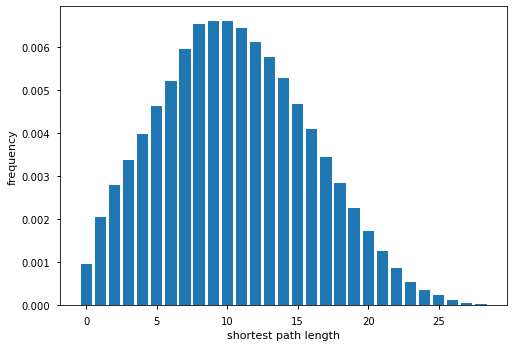

In [59]:
bincounts = [np.bincount(row, minlength=max_length+1) for row in lengths.to_numpy()]
freqs = np.sum(bincounts, axis=0) / lengths.sum().sum()
plt.bar(np.arange(max_length+1), freqs)
plt.xlabel("shortest path length")
plt.ylabel("frequency")
plt.show()

*d) Write your own subway app: Make a function that get the subway network, a start and end station and returns the shortest connection. Try it out with start='Schoenbrunn' and end='Donauinsel'. To avoid running into to many tourists you want to get around 'Stephansdom'. How does that change your result?*

In [60]:
def route(G, start_node, end_node, avoid_tourists=False):
    G = G.copy()
    if avoid_tourists and start_node != "Stephansplatz" and end_node != "Stephansplatz":
        G.remove_node("Stephansplatz")
    return nx.shortest_path(G, start_node, end_node)

In [61]:
route(G, "Schoenbrunn", "Donauinsel")

['Schoenbrunn',
 'Meidling Haupstrasse',
 'Laengenfeldgasse',
 'Margaretenguertel',
 'Pilgramgasse',
 'Kettenbrueckengasse',
 'Karlsplatz',
 'Stephansplatz',
 'Schwedenplatz',
 'Nestroyplatz',
 'Praterstern',
 'Vorgartenstrasse',
 'Donauinsel']

In [62]:
route(G, "Schoenbrunn", "Donauinsel", avoid_tourists=True)

['Schoenbrunn',
 'Meidling Haupstrasse',
 'Laengenfeldgasse',
 'Margaretenguertel',
 'Pilgramgasse',
 'Kettenbrueckengasse',
 'Karlsplatz',
 'Stadtpark',
 'Landstrasse',
 'Schwedenplatz',
 'Nestroyplatz',
 'Praterstern',
 'Vorgartenstrasse',
 'Donauinsel']

*e) Perturbations/Vulnerabilities: Suppose your app is connected to a news feed that informs your system about temporally occuring traffic perturbations or station closures. Add a optional argument to your function that get a station to avoid.*

In [63]:
def route(G, start_node, end_node, avoid=None):
    G = G.copy()
    if avoid is not None:
        try:
            for station in avoid:
                G.remove_node(station)
        except TypeError:
            G.remove_node(avoid)
    return nx.shortest_path(G, start_node, end_node)

In [64]:
route(G, "Schoenbrunn", "Donauinsel", avoid=["Stephansplatz", "Schwedenplatz"])

['Schoenbrunn',
 'Meidling Haupstrasse',
 'Laengenfeldgasse',
 'Gumpendorfer strasse',
 'Westbahnhof',
 'Zieglergasse',
 'Neubaugasse',
 'Volkstheater',
 'Rathaus',
 'Schottentor',
 'Schottenring',
 'Taborstrasse',
 'Praterstern',
 'Vorgartenstrasse',
 'Donauinsel']